**Lab2-DL: A4-MNIST-Random-Forest.ipynb** (ELMED219) | Prioritet: 3 (valgfri)

_MNIST-klassifisering med Random Forest – en ML baseline_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A4-MNIST-Random-Forest.ipynb)


Sist oppdatert: 2025-01-18, A. Lundervold

Bruk `elmed219` conda-miljøet eller Google Colab

---

### NB 2: MNIST-klassifisering med Random Forest

Denne notebooken demonstrerer bildeklassifisering med tradisjonell maskinlæring (Random Forest) som baseline før vi går videre til dyp læring. Bygger på notebook 01.

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


### Import libraries

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

Loading MNIST data from CSV...
Data dimensions: (5000, 785)


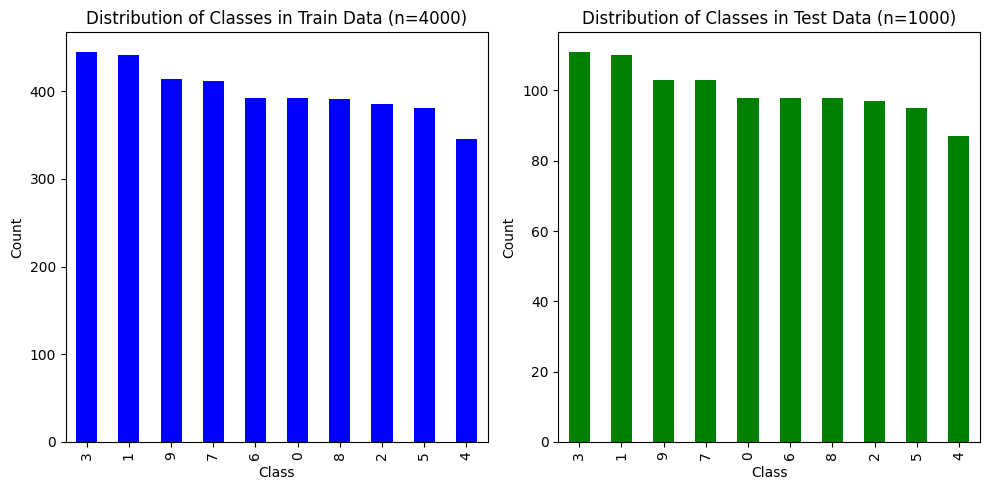

In [ ]:
# Notebook 2: MNIST Classification using Random Forest
# ================================================
# Denne notebooken demonstrerer klassifisering av MNIST-siffer med Random Forest
# på tabulær representasjon av dataene.

# 1. Datalasting og stratifisert oppdeling
# ----------------------------------------

# Opprett mappe for MNIST-data hvis den ikke finnes
os.makedirs('mnist_images', exist_ok=True)
csv_path = 'mnist_images/mnist_data_5000x785.csv'

# Sjekk om CSV-filen allerede finnes
if os.path.exists(csv_path):
    print("Laster MNIST-data fra lokal CSV-fil...")
    mnist_data = pd.read_csv(csv_path)
else:
    print("Genererer MNIST-data fra PyTorch (lastes ned ved første kjøring)...")
    from torchvision import datasets
    import torchvision.transforms as transforms
    
    # Last ned MNIST via PyTorch
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, 
                                  transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, 
                                 transform=transforms.ToTensor())
    
    # Konverter til numpy og kombiner
    X_train = mnist_train.data.numpy().reshape(60000, -1) / 255.0
    X_test = mnist_test.data.numpy().reshape(10000, -1) / 255.0
    y_train = mnist_train.targets.numpy()
    y_test = mnist_test.targets.numpy()
    
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])
    
    # Ta et tilfeldig utvalg på 5000 samples
    np.random.seed(42)
    indices = np.random.choice(len(X), 5000, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Lag DataFrame
    feature_names = [f'pixel_{i}' for i in range(784)]
    mnist_data = pd.DataFrame(X_sample, columns=feature_names)
    mnist_data['label'] = y_sample
    
    # Lagre til CSV for fremtidig bruk
    mnist_data.to_csv(csv_path, index=False)
    print(f"Data lagret til {csv_path}")

# Print dimensions of the data
print(f"Data dimensions: {mnist_data.shape}")

# Split into training and test data, stratified by class
train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42, stratify=mnist_data['label'])

# Separate features (already normalized) and labels
X_train = train_data.drop('label', axis=1) 
y_train = train_data['label']
X_test = test_data.drop('label', axis=1) 
y_test = test_data['label']

# Plot distributions of classes (digitis) in train data and test data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color='blue')
plt.title(f'Distribution of Classes in Train Data (n={len(y_train)})')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', color='green')
plt.title(f'Distribution of Classes in Test Data (n={len(y_test)})')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


First 5 labels in train_data:
1339    0
3053    6
2728    1
1369    7
124     8
Name: label, dtype: int64


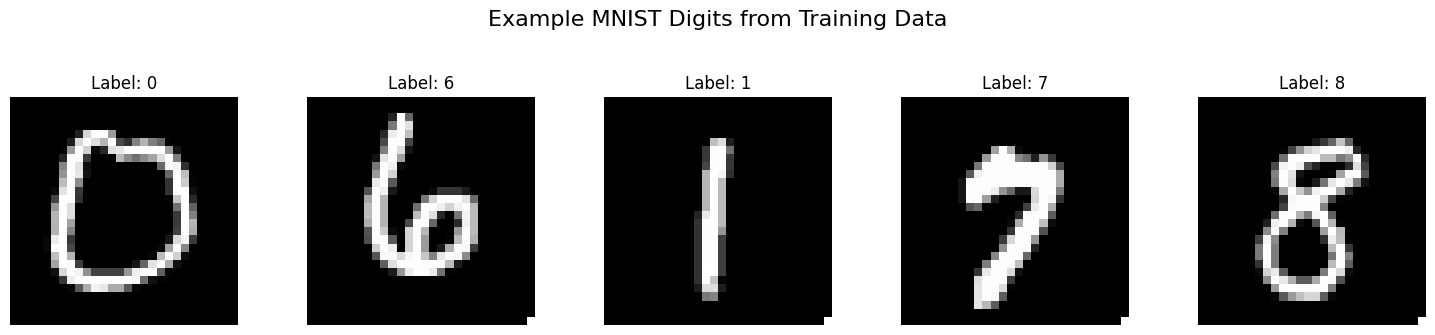

In [4]:
# 2. Data Visualization
# --------------------
# First, let's check what labels we actually have in train_data
print("First 5 labels in train_data:")
print(train_data['label'].head())

def plot_digit(data, index, predictions=None):
    """Plot a single MNIST digit."""
    digit = data.iloc[index, 1:].values.reshape(28, 28)
    plt.imshow(digit, cmap='gray', vmin=0, vmax=1)  # Added contrast control
    plt.axis('off')
    
    # Add debug print to verify the label being accessed
    true_label = int(data.iloc[index]['label'])  # Access 'label' column directly
    if predictions is not None:
        pred_label = int(predictions[index])
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    else:
        plt.title(f'Label: {true_label}')

# Plot a few example digits
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_digit(train_data, i)
plt.suptitle("Example MNIST Digits from Training Data", y=1.1, fontsize=16)  # Added data source
plt.tight_layout()
plt.show()

In [5]:
# 3. Model Training
# ----------------
print("Training Random Forest classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

Training Random Forest classifier...


RandomForestClassifier(random_state=42)

Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        98
           1       0.93      0.98      0.96       110
           2       0.91      0.94      0.92        97
           3       0.92      0.90      0.91       111
           4       0.93      0.91      0.92        87
           5       0.89      0.89      0.89        95
           6       0.97      0.97      0.97        98
           7       0.92      0.90      0.91       103
           8       0.84      0.80      0.82        98
           9       0.90      0.92      0.91       103

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



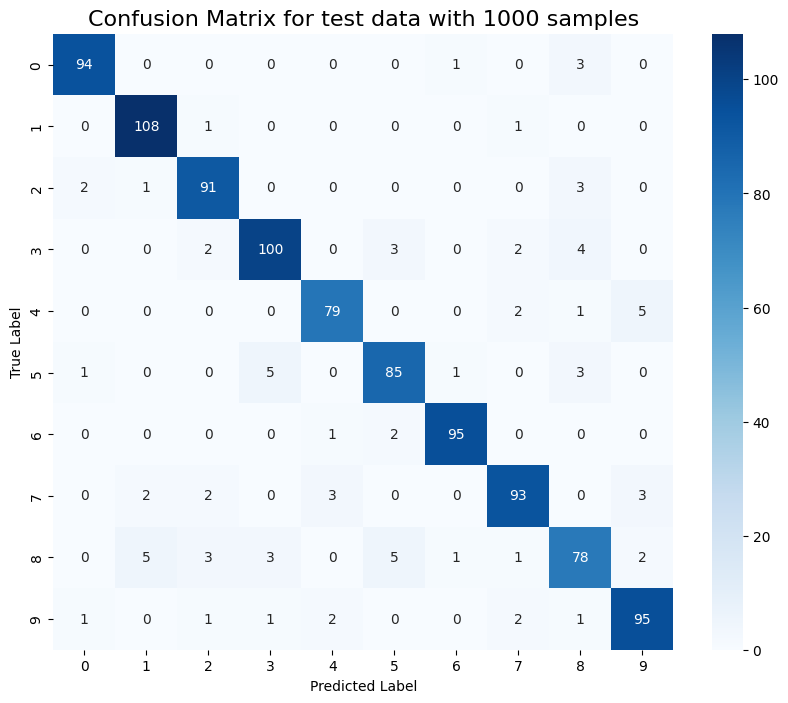

In [6]:
# 4. Model Evaluation
# ------------------
print("Evaluating model performance...")
y_pred = rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# Add title and labels to the plot
plt.title(f'Confusion Matrix for test data with {len(y_test)} samples', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [7]:
# Calculate and display various performance metrics
# --------

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Macro averages
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Performance Metrics for MNIST Digit Classification:\n")

print("1. Overall Accuracy:")
print(f"   Definition: Proportion of correct predictions among total predictions")
print(f"   Value: {accuracy:.3f} ({accuracy*100:.1f}%)\n")

print("2. Per-class Precision:")
print("   Definition: Proportion of correct positive predictions for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {precision[digit]:.3f}")
print(f"   Macro-average precision: {macro_precision:.3f}\n")

print("3. Per-class Recall (Sensitivity):")
print("   Definition: Proportion of actual positives correctly identified for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {recall[digit]:.3f}")
print(f"   Macro-average recall: {macro_recall:.3f}\n")

print("4. Per-class F1-Score:")
print("   Definition: Harmonic mean of precision and recall for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {f1[digit]:.3f}")
print(f"   Macro-average F1-score: {macro_f1:.3f}\n")

# Calculate error rate
error_rate = 1 - accuracy
print("5. Error Rate:")
print("   Definition: Proportion of incorrect predictions among total predictions")
print(f"   Value: {error_rate:.3f} ({error_rate*100:.1f}%)")

Performance Metrics for MNIST Digit Classification:

1. Overall Accuracy:
   Definition: Proportion of correct predictions among total predictions
   Value: 0.918 (91.8%)

2. Per-class Precision:
   Definition: Proportion of correct positive predictions for each digit
   Digit 0: 0.959
   Digit 1: 0.931
   Digit 2: 0.910
   Digit 3: 0.917
   Digit 4: 0.929
   Digit 5: 0.895
   Digit 6: 0.969
   Digit 7: 0.921
   Digit 8: 0.839
   Digit 9: 0.905
   Macro-average precision: 0.918

3. Per-class Recall (Sensitivity):
   Definition: Proportion of actual positives correctly identified for each digit
   Digit 0: 0.959
   Digit 1: 0.982
   Digit 2: 0.938
   Digit 3: 0.901
   Digit 4: 0.908
   Digit 5: 0.895
   Digit 6: 0.969
   Digit 7: 0.903
   Digit 8: 0.796
   Digit 9: 0.922
   Macro-average recall: 0.917

4. Per-class F1-Score:
   Definition: Harmonic mean of precision and recall for each digit
   Digit 0: 0.959
   Digit 1: 0.956
   Digit 2: 0.924
   Digit 3: 0.909
   Digit 4: 0.919
   Dig

#### Interim summary and interpretation of the results

Let me analyze these MNIST classification results:

**Overall Performance:**
- 91.8% accuracy is strong for a Random Forest on MNIST
- 8.2% error rate is reasonable
- Consistent performance across metrics (precision, recall, F1)

**Digit-Specific Analysis:**

**Best Performers:**
1. Digit 6: 
   - Highest precision (0.969)
   - Highest recall (0.969)
   - Most reliable classification
   - Likely due to distinctive shape

2. Digit 0:
   - Very high precision/recall (0.959)
   - Consistent performance
   - Simple, circular shape helps recognition

**Challenging Digits:**
1. Digit 8:
   - Lowest precision (0.839)
   - Lowest recall (0.796)
   - Most problematic digit
   - Often confused with similar shapes (0,6,9)

2. Digit 5:
   - Below average (0.895)
   - Moderate confusion rate
   - Complex shape variations

**Key Observations:**
1. **Balanced Performance:**
   - Small gap between precision/recall
   - Consistent across most digits
   - No major class imbalance issues

2. **Pattern Recognition:**
   - Simpler shapes (0,1,6) → better performance
   - Complex shapes (8,5) → more errors
   - Expected pattern for visual recognition

**Clinical Relevance:**
This type of analysis is similar to diagnostic test evaluation:
- High precision = few false positives
- High recall = few false negatives
- F1-score = balanced diagnostic performance

The model shows reliable performance suitable for automated digit recognition tasks.


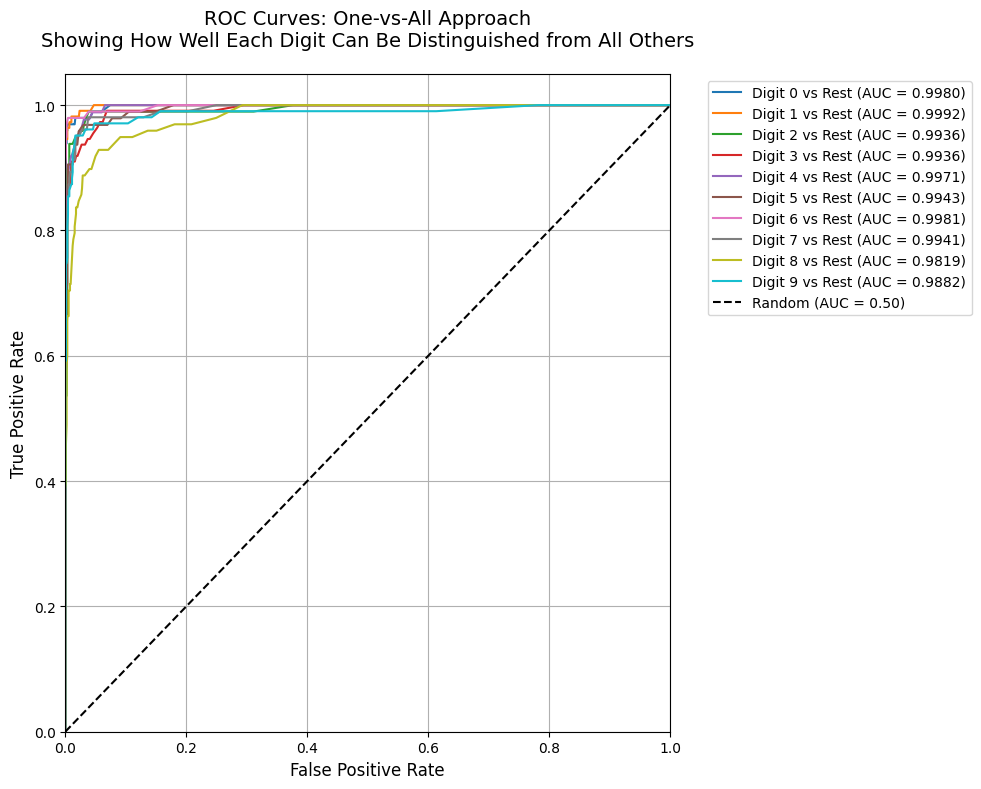


ROC AUC Interpretation:
Each curve shows how well the model can distinguish one digit from all others.
For example, 'Digit 5 vs Rest' shows how well the model can:
- Correctly identify 5s (True Positive Rate)
- Avoid mislabeling other digits as 5 (False Positive Rate)

Per-digit ROC AUC scores:
Digit 0 vs Rest: 0.9980
Digit 1 vs Rest: 0.9992
Digit 2 vs Rest: 0.9936
Digit 3 vs Rest: 0.9936
Digit 4 vs Rest: 0.9971
Digit 5 vs Rest: 0.9943
Digit 6 vs Rest: 0.9981
Digit 7 vs Rest: 0.9941
Digit 8 vs Rest: 0.9819
Digit 9 vs Rest: 0.9882

ROC AUC Scores:
Definition: Area Under the Receiver Operating Characteristic Curve
Mean ROC AUC: 0.9938


In [8]:
#  Calculate and plot the ROC AUC curves for each digit (one-vs-all approach) 
#  since this is a multi-class problem:

# Get probability predictions
y_prob = rf_classifier.predict_proba(X_test)

# Binarize the labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=range(10))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for digit in range(10):
    # For each digit:
    # y_test_bin[:, digit] = 1 for the current digit, 0 for all others
    # y_prob[:, digit] = probability of being the current digit
    fpr[digit], tpr[digit], _ = roc_curve(y_test_bin[:, digit], y_prob[:, digit])
    roc_auc[digit] = auc(fpr[digit], tpr[digit])
    plt.plot(fpr[digit], tpr[digit],
             label=f'Digit {digit} vs Rest (AUC = {roc_auc[digit]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: One-vs-All Approach\nShowing How Well Each Digit Can Be Distinguished from All Others', 
          fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print interpretation
print("\nROC AUC Interpretation:")
print("Each curve shows how well the model can distinguish one digit from all others.")
print("For example, 'Digit 5 vs Rest' shows how well the model can:")
print("- Correctly identify 5s (True Positive Rate)")
print("- Avoid mislabeling other digits as 5 (False Positive Rate)")
print("\nPer-digit ROC AUC scores:")
for digit in range(10):
    print(f"Digit {digit} vs Rest: {roc_auc[digit]:.4f}")


# Print average AUC
mean_auc = sum(roc_auc.values()) / 10
print("\nROC AUC Scores:")
print("Definition: Area Under the Receiver Operating Characteristic Curve")
print(f"Mean ROC AUC: {mean_auc:.4f}")

#### Interpretation of the ROC AUC results

Let me analyze these ROC (Receiver Operating Characteristic) curves:

**Overall Performance:**
- All digits show excellent AUC (Area Under Curve) scores > 0.98
- Far above random performance (dashed line, AUC = 0.50)
- Indicates strong discriminative ability for all digits

**Best Performers:**
1. Digit 1 (AUC = 0.9992)
   - Highest AUC
   - Very steep initial curve
   - Suggests excellent separation from other digits
   - Makes sense due to simple, distinctive shape

2. Digit 4 (AUC = 0.9971)
   - Second-best performer
   - Strong early true positive rate
   - Distinctive angular features help recognition

**Lower Performers:**
1. Digit 8 (AUC = 0.9819)
   - Lowest AUC, but still excellent
   - Slightly more gradual curve
   - Confirms earlier metrics showing more confusion
   - Complex shape shares features with 0, 6, 9

**Clinical Interpretation:**
- ROC curves show trade-off between:
  - Sensitivity (True Positive Rate)
  - Specificity (1 - False Positive Rate)
- All digits achieve near-perfect classification
- Different operating points possible for different needs
- Model maintains high performance across all thresholds

**Practical Significance:**
- Exceptional discrimination ability
- Reliable across all digit classes
- Suitable for automated digit recognition
- Very low risk of confusion between digits


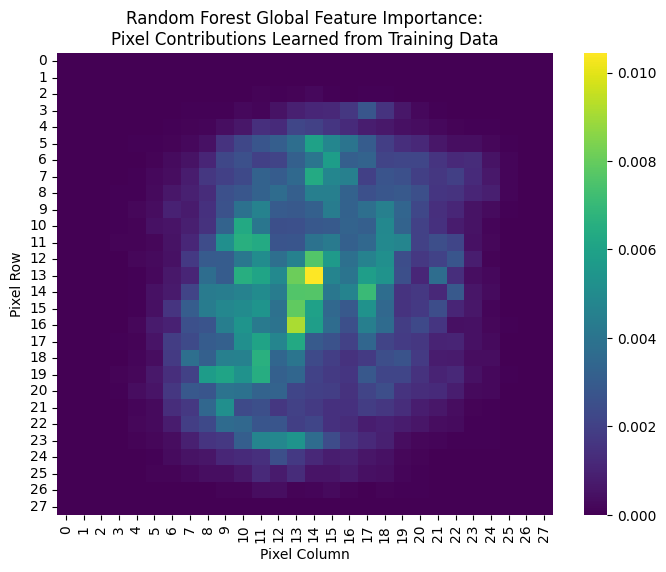

In [9]:
# 5. Feature Importance Analysis
# ----------------------------
# Get feature importance scores
importance = rf_classifier.feature_importances_
pixel_importance = importance.reshape(28, 28)

# Plot feature importance heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pixel_importance, cmap='viridis')
plt.title('Random Forest Global Feature Importance:\nPixel Contributions Learned from Training Data')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

#### Interpretation of the feature importance results


This feature importance heatmap shows which pixel locations in the MNIST digit images were most important for the Random Forest classifier's decisions:

**Key Observations:**

1. **Central Region Importance:**
   - Brightest spots (yellow/green) in the center
   - Pixels around (13-15, 13-15) have highest importance
   - Makes sense as digits typically occupy central area

2. **Pattern Distribution:**
   - Circular/oval pattern of importance
   - Matches typical digit writing patterns
   - Edges/corners have minimal importance (dark purple)

3. **Importance Values:**
   - Scale from 0.000 (purple) to 0.010 (yellow)
   - Most informative pixels contribute ~1% to decisions
   - Distributed decision-making (no single dominant pixel)

**Practical Interpretation:**
1. **Writing Patterns:**
   - Model focuses on where people typically write
   - Ignores empty corners/edges
   - Aligns with human visual attention

2. **Model Behavior:**
   - Uses central region for key decisions
   - Considers surrounding context
   - Robust to digit position variations

3. **Clinical Analogy:**
   - Like a radiologist focusing on relevant image regions
   - Ignores irrelevant background areas
   - Uses spatial patterns for classification

This visualization confirms the model has learned meaningful spatial patterns for digit recognition, focusing on the most informative regions of the images.


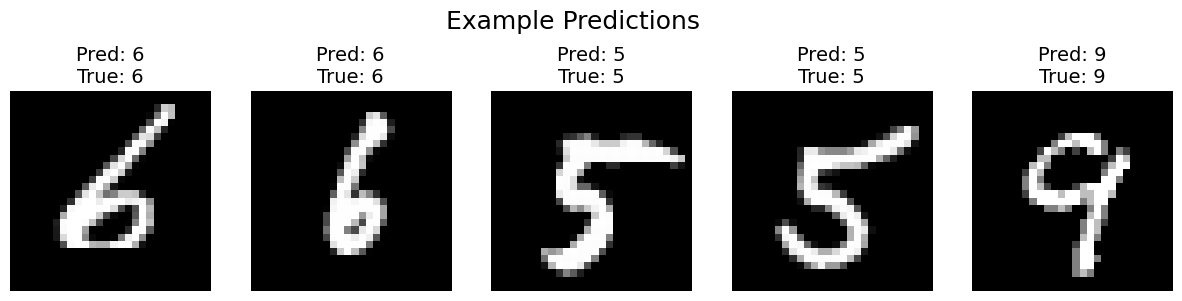

In [10]:
# 6. Example Predictions
# --------------------
# Select a few test examples
n_examples = 5
example_indices = np.random.randint(0, len(X_test), n_examples)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(example_indices):
    plt.subplot(1, 5, i+1)
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    # Convert to DataFrame with proper feature names to avoid the warning
    example_data = pd.DataFrame([X_test.iloc[idx]], columns=X_train.columns)
    pred = rf_classifier.predict(example_data)[0]
    true = y_test.iloc[idx]
    plt.title(f'Pred: {pred}\nTrue: {true}', fontsize=14)  # Increased subplot title font size
plt.suptitle("Example Predictions", y=1.1, fontsize=18)  # Increased suptitle font size
plt.show()

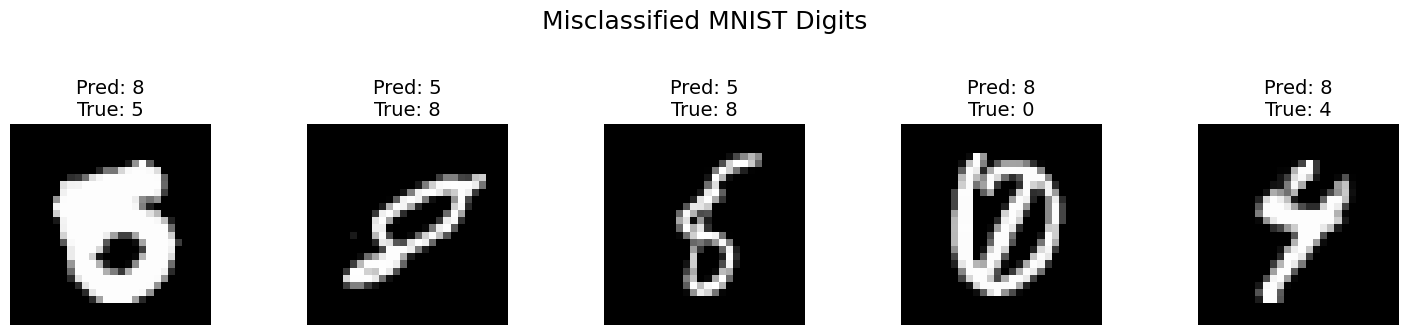

In [11]:
# 7. Example Misclassifications
# ---------------------------
# Find misclassified examples
y_pred = rf_classifier.predict(X_test)
misclassified_idx = np.where(y_test != y_pred)[0]

# Plot up to 5 misclassified examples
n_examples = min(5, len(misclassified_idx))
plt.figure(figsize=(15, 3))

for i in range(n_examples):
    plt.subplot(1, 5, i+1)
    idx = misclassified_idx[i]
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    pred = y_pred[idx]
    true = y_test.iloc[idx]
    plt.title(f'Pred: {pred}\nTrue: {true}', fontsize=14)  # Increased subplot title font size

plt.suptitle("Misclassified MNIST Digits", y=1.1, fontsize=18)  # Increased suptitle font size
plt.tight_layout()
plt.show()

#### Comments to misclassification results


Let's analyze these misclassified MNIST digits:

**1. First Error (Pred: 8, True: 5)**
- Model confused a "5" for an "8"
- Understandable error due to:
  - Similar curved structure
  - Loop in the "5" resembling "8"
  - Common confusion pattern

**2. Second Error (Pred: 5, True: 8)**
- Opposite confusion of first case
- Shows systematic confusion between 5/8
- Tilted orientation might have contributed
- Demonstrates reciprocal error pattern

**3. Third Error (Pred: 5, True: 8)**
- Another 5/8 confusion
- Different writing style
- More angular appearance
- Confirms systematic 5/8 confusion issue

**4. Fourth Error (Pred: 8, True: 0)**
- Model confused "0" for "8"
- Both digits have closed loops
- Similar circular structure
- Expected confusion due to shape similarity

**5. Fifth Error (Pred: 8, True: 4)**
- Model saw "8" in a "4"
- Unusual writing style of "4"
- Curved structure might have misled model
- Less common confusion pattern

**Key Patterns:**
1. Most errors involve digit "8"
2. Strong 5/8 confusion pattern
3. Shape similarities drive errors
4. Writing style variations cause problems

**Recommendations:**
1. Add more training examples of 5/8 variations
2. Focus on distinguishing features between similar digits
3. Consider data augmentation with rotations
4. Possibly add attention to key distinguishing features

These misclassifications show understandable confusions based on structural similarities between digits.




In [12]:
# 8. Save the Model (Optional)
# --------------------------
import joblib
joblib.dump(rf_classifier, f'mnist_images/mnist_random_forest_5000x785.joblib')
print(f"\nModel saved as 'mnist_images/mnist_random_forest_5000x785.joblib'")



Model saved as 'mnist_images/mnist_random_forest_5000x785.joblib'


### Here's how to load and apply the saved Random Forest model to new data:

````python
# 1. Load the saved model
import joblib

# Load the model
rf_classifier = joblib.load('mnist_images/mnist_random_forest_5000x785.joblib')

# 2. Apply to new data
def predict_digit(image_data, model):
    """
    Predict digit from preprocessed image data.
    
    Args:
        image_data: Flattened image array (785 features)
        model: Loaded Random Forest classifier
    Returns:
        prediction, probability
    """
    # Ensure data is in correct format (flatten if needed)
    if image_data.ndim > 1:
        image_data = image_data.flatten()
    
    # Make prediction
    prediction = model.predict([image_data])[0]
    probabilities = model.predict_proba([image_data])[0]
    
    return prediction, probabilities

# Example usage:
# new_image = ... # Your 28x28 image data
# pred, probs = predict_digit(new_image, rf_classifier)
# print(f"Predicted digit: {pred}")
# print(f"Confidence: {probs[pred]:.2%}")
````

Key points:
1. Model loading is simple with joblib
2. Input must match training format (785 features)
3. Returns both prediction and probabilities
4. Can be used in a pipeline for batch processing

Remember to preprocess new data exactly like the training data!
